# <font color=blue> Analysis of GFP invasion experiments
***

javascript to avoid the need of scrolling :

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

##Parameters
# apico-basal length of tissue in um
L = 50.;
#number of points on the grid
N_grid = 400; 
#space interval
dx = L/float(N_grid);
#space grid
X = np.linspace(0,
                (1-1.0 / N_grid) * L,
                N_grid)
#temporal grid (time given in s)
t0 = np.linspace(0, 300, 301);
dt = t0[1] - t0[0]
#intercellular space width in um
h_value = 0.02;
#diffusion constant of receptors in um^2/s
D_r_value = 1.36 
#free diffusion constant of GFP in um^2/s
#twice as high because apico-basal intercellular space is straight
D_f_value = 42. 
#kon rate of ligand to receptor in nM^(-1).s^(-1)
k_on_value = 7.7 * 10**-4; 
#koff rate of ligand to receptor in s^(-1)
k_off_value = 1.7 * 10**-4; 
#receptor density at the cell surface in nM.um
nT_value = 80. 
#tolerance
tol = 1.0e-5

def ode_invasion(y, t, D_f, D_r, k_on, k_off, L, h, C_S):
    """function which returns the time evolution of the 
    concentration fields c (free GFP), nb (GFP bound to receptor)
    nf (free receptor) 
    x=0 is the basal side in contact with the bath
    x=L is the apical side
    D_f the free diffusion of GFP
    D_r the diffusion of receptor in the membrane
    k_on the on-rate of ligands to receptor
    k_off the off-rate of ligands to receptor
    L the apico-basal distance
    h the size of the intercellular space
    C_S the concentraton in the bath
    """
    #vector containinig the time derivative for the fields
    dydt = np.zeros(3*N_grid);
    # extract the three fields from the vector y
    c = y[0::3];
    nb = y[1::3];
    nf = y[2::3];   
    #calculate time derivatives
    dcdt = np.zeros(N_grid);
    dnbdt = np.zeros(N_grid);
    dnfdt = np.zeros(N_grid)
    #near the bath, uses that the concentration in the bath is C_S (c[-1]=C_S)
    #and that there is a vanishing flux of nb and nf (nb[-1]=nb[0], nf[-1]=nf[0])
    dcdt[0] = (D_f / dx ** 2 * (c[1] + C_S - 2.0 * c[0])
               + 1.0 / h * (- k_on * nf[0] * c[0] + k_off * nb[0]))
    dnbdt[0] = (D_r / dx ** 2 * (nb[1] - nb[0]) 
                + k_on * nf[0] * c[0] - k_off * nb[0])
    dnfdt[0] = (D_r / dx ** 2 * (nf[1] - nf[0])
                - k_on * nf[0] * c[0] + k_off * nb[0])
    #in bulk, standard discrete diffusion operator
    for i in np.arange(1, N_grid-1):
        dcdt[i] = (D_f / dx ** 2 * (c[i+1] + c[i-1] - 2 * c[i]) 
                  + 1.0 / h * (-k_on * nf[i] * c[i] + k_off * nb[i]))
        dnbdt[i] = (D_r / dx ** 2 * (nb[i+1] + nb[i-1] - 2 * nb[i]) 
                    + k_on * nf[i] * c[i] - k_off * nb[i])
        dnfdt[i] = (D_r / dx ** 2 * (nf[i+1] + nf[i-1] - 2 * nf[i])
                    - k_on * nf[i] * c[i] + k_off * nb[i])
    #near the apical side, uses that there is a vanishing flux of c (c[N+1]=c[N]=c[-1])
    #and that there is a vanishing flux of nb and nf (nb[N+1]=nb[N], nf[N+1]=nf[N])
    dcdt[-1] = (D_f / dx ** 2 * (c[-2] - c[-1]) 
                + 1.0 / h * (-k_on * nf[-1] * c[-1] + k_off * nb[-1]))
    dnbdt[-1] = (D_r / dx ** 2 *(nb[-2] - nb[-1])
                 + k_on * nf[-1] * c[-1] - k_off * nb[-1])
    dnfdt[-1] = (D_r/dx ** 2 * (nf[-2] - nf[-1]) 
                 - k_on * nf[-1] * c[-1] + k_off * nb[-1])
    
    dydt[0::3] = dcdt;
    dydt[1::3] = dnbdt;
    dydt[2::3] = dnfdt; 
    return np.squeeze(np.asarray(dydt))

Solve the PDEs for the evolution of the concentration field, for the 3 bath concentrations of 2nM, 20nM, 200nM

In [21]:
#initial conditions: no free GFP, no bound GFP, only unbound receptors.
y0 = np.zeros(3*N_grid);
y0[2::3] = nT_value
y0 = np.squeeze(np.asarray(y0))
#solution with bath concentration 2nM
S2, infodictold0 = integrate.odeint(ode_invasion,
                                    y0,
                                    t0,
                                    args=(D_f_value, D_r_value, k_on_value, k_off_value, L, h_value, 2.,),
                                    full_output=True,
                                    rtol=tol,
                                    atol=tol)
#solution with bath concentration 20nM
S20, infodictold0 = integrate.odeint(ode_invasion,
                                     y0,
                                     t0,
                                     args=(D_f_value, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                     full_output=True,
                                     rtol=tol,
                                     atol=tol)
#solution with bath concentration 200nM
S200, infodictold0 = integrate.odeint(ode_invasion,
                                      y0,
                                      t0,
                                      args=(D_f_value, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                      full_output=True,
                                      rtol=tol,
                                      atol=tol)
# Record Bound profiles (used for the statistical analysis):
nb2 = S200[:,1::3]
m = np.mean(nb2[-1])
nb0 = S2[:,1::3][-1] / m
nb1 = S20[:,1::3][-1] / m
nb2 = S200[:,1::3][-1] / m

## Fig S7-G Plotting GFP invasion profiles : 


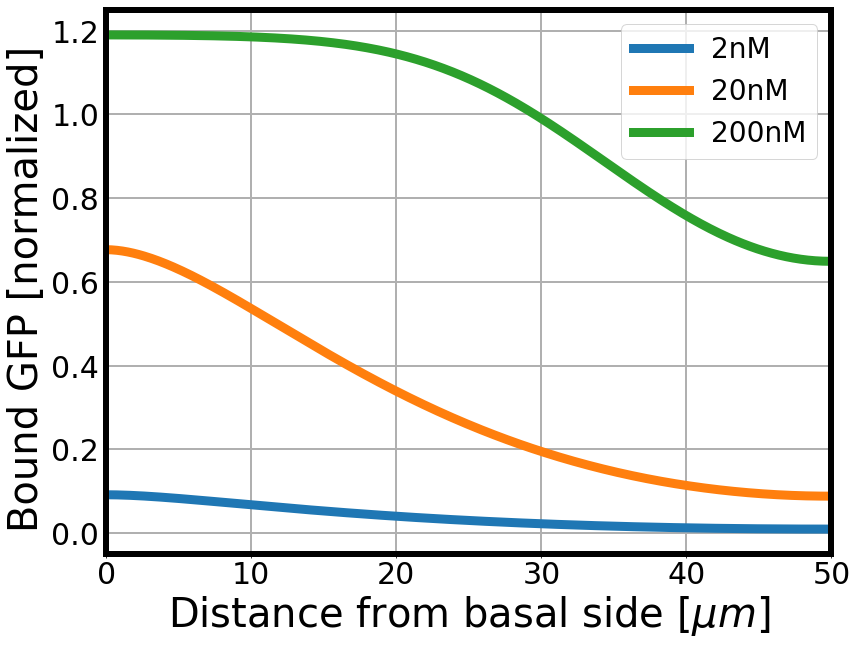

In [22]:
f=plt.figure(figsize = (13, 10))
ax1 = plt.subplot(111)
ax1.plot(X, nb0, label = "2nM", lw=9, ms = 10)
ax1.plot(X, nb1, label = "20nM", lw=9, ms = 10)
ax1.plot(X, nb2, label = "200nM", lw=9, ms = 10)
ax1.set_xlim(-5, 50)
plt.tick_params(labelsize=30)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(6)
plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from basal side $[\mu m] $",fontsize =40)
plt.legend(['2nM','20nM','200nM'],fontsize=28)
plt.grid(lw=2)
plt.xlim([0, 50])
plt.savefig('./Figures/Fig-S7-G.eps',format='eps',dpi=600)
plt.show()

Plot solution for concentration profiles at different times.

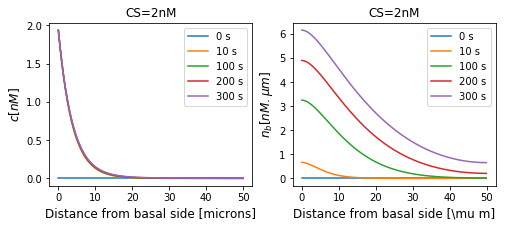

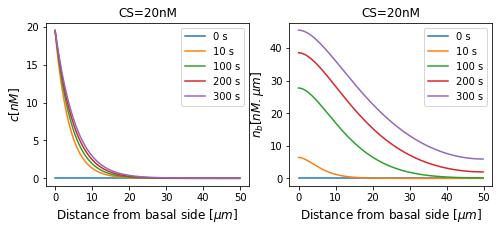

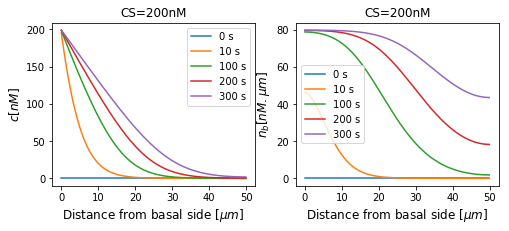

In [47]:
#array to contain labels of plots
leg = []
#font size 
Fsize = 12
selected_times_array = [0, 10, 100, 200, 300]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S2[time_index, 0::3])
    ax2.plot(X,S2[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [microns]',fontsize=Fsize);
ax2.set_xlabel('Distance from basal side [\mu m]',fontsize=Fsize);
ax1.set_ylabel(r'$c[nM]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax2.legend(leg)
ax1.set_title('CS=2nM',fontsize=Fsize)
ax2.set_title('CS=2nM',fontsize=Fsize)
leg=[]
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S20[time_index, 0::3])
    ax2.plot(X,S20[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [$\mu m$]',fontsize=Fsize);
ax2.set_xlabel(r'Distance from basal side [$\mu m$]',fontsize=Fsize);
ax1.set_ylabel(r'$c[nM]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax2.legend(leg)
leg=[]
ax1.set_title('CS=20nM',fontsize=Fsize)
ax2.set_title('CS=20nM',fontsize=Fsize)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S200[time_index, 0::3])
    ax2.plot(X,S200[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [$\mu m$]',fontsize=Fsize);
ax2.set_xlabel(r'Distance from basal side [$\mu m$]',fontsize=Fsize);
ax1.set_ylabel(r'$c[nM]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax1.set_title('CS=200nM',fontsize=Fsize)
ax2.set_title('CS=200nM',fontsize=Fsize)
ax2.legend(leg)
plt.show()

Plot concentration profiles, but plotting c x h and nb to have a comparison of their magnitudes.
Ch is generally much lower than nb. We assume that the free concentration does not contribute because it is removed by experimental manipulation.

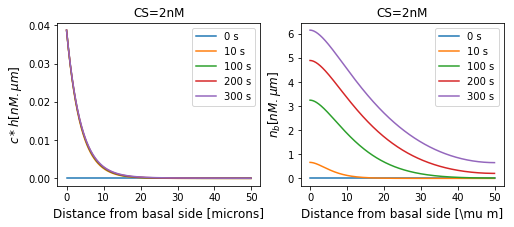

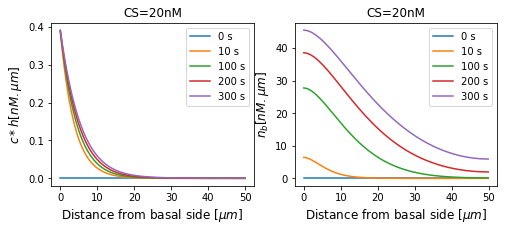

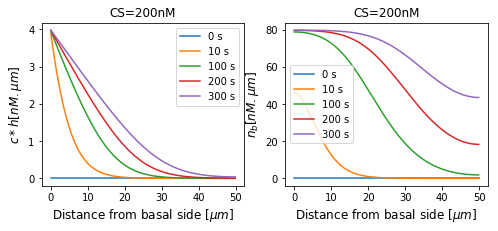

In [39]:
#array to contain labels of plots
leg = []
#font size 
Fsize = 12
selected_times_array = [0, 10, 100, 200, 300]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S2[time_index, 0::3] * h_value)
    ax2.plot(X,S2[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [microns]',fontsize=Fsize);
ax2.set_xlabel('Distance from basal side [\mu m]',fontsize=Fsize);
ax1.set_ylabel(r'$c * h [nM.\mu m]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax2.legend(leg)
ax1.set_title('CS=2nM',fontsize=Fsize)
ax2.set_title('CS=2nM',fontsize=Fsize)
leg=[]
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S20[time_index, 0::3] * h_value)
    ax2.plot(X,S20[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [$\mu m$]',fontsize=Fsize);
ax2.set_xlabel(r'Distance from basal side [$\mu m$]',fontsize=Fsize);
ax1.set_ylabel(r'$c * h [nM.\mu m]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax2.legend(leg)
leg=[]
ax1.set_title('CS=20nM',fontsize=Fsize)
ax2.set_title('CS=20nM',fontsize=Fsize)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 3))
for time in selected_times_array: 
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X,S200[time_index, 0::3] * h_value)
    ax2.plot(X,S200[time_index, 1::3])
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [$\mu m$]',fontsize=Fsize);
ax2.set_xlabel(r'Distance from basal side [$\mu m$]',fontsize=Fsize);
ax1.set_ylabel(r'$c * h [nM.\mu m]$',fontsize=Fsize);
ax2.set_ylabel(r'$n_b[nM.\mu m]$',fontsize=Fsize);
ax1.set_title('CS=200nM',fontsize=Fsize)
ax2.set_title('CS=200nM',fontsize=Fsize)
ax2.legend(leg)
plt.show()

Plot profiles of spatial derivatives of the profiles

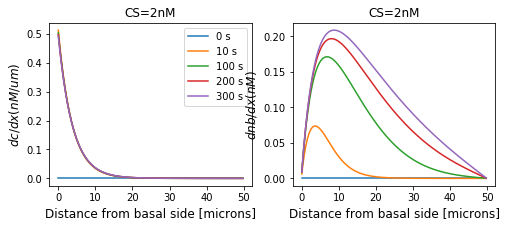

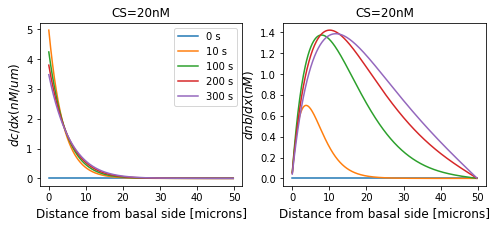

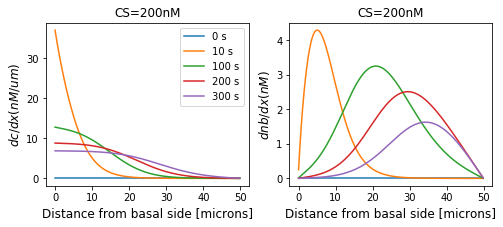

In [48]:
# here plot profiles of dc/dx and dnb/dx
dt = t0[1] - t0[0]
## plots for 2 nM
leg=[]
Fsize=12
selected_times_array = [0, 10, 100, 200, 300]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
for time in selected_times_array: 
    #for each time, find the corresponding index in the list
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X[:-1], np.array((S2[time_index, 0::3][0: -1]-S2[time_index, 0::3][1:])/dx))
    ax2.plot(X[:-1], np.array((S2[time_index, 1::3][0: -1]-S2[time_index, 1::3][1:])/dx))
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax1.set_ylabel(r'$dc/dx (nM/um)$', fontsize=Fsize);
ax1.set_title('CS=2nM', fontsize=Fsize)
ax2.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax2.set_ylabel(r'$dnb/dx (nM)$', fontsize=Fsize);
ax2.set_title('CS=2nM', fontsize=Fsize)

## plots for 20 nM
leg=[]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
for time in selected_times_array: 
    #for each time, find the corresponding index in the list
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X[: -1], np.array((S20[time_index, 0::3][0: -1]-S20[time_index, 0::3][1:])/dx))
    ax2.plot(X[: -1], np.array((S20[time_index, 1::3][0: -1]-S20[time_index, 1::3][1:])/dx))
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax1.set_ylabel(r'$dc/dx (nM/um)$', fontsize=Fsize);
ax1.set_title('CS=20nM', fontsize=Fsize)
ax2.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax2.set_ylabel(r'$dnb/dx (nM)$', fontsize=Fsize);
ax2.set_title('CS=20nM', fontsize=Fsize)

## plots for 200 nM
leg=[]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
for time in selected_times_array: 
    #for each time, find the corresponding index in the list
    time_index = np.argmin(np.abs(t0 - time))
    leg.append(str(time) + ' s')
    ax1.plot(X[:-1], np.array((S200[time_index, 0::3][0:-1]-S200[time_index, 0::3][1:])/dx))
    ax2.plot(X[:-1], np.array((S200[time_index, 1::3][0:-1]-S200[time_index, 1::3][1:])/dx))
ax1.legend(leg);
ax1.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax1.set_ylabel(r'$dc/dx (nM/um)$', fontsize=Fsize);
ax1.set_title('CS=200nM', fontsize=Fsize)
ax2.set_xlabel('Distance from basal side [microns]', fontsize=Fsize);
ax2.set_ylabel(r'$dnb/dx (nM)$', fontsize=Fsize);
ax2.set_title('CS=200nM', fontsize=Fsize)
plt.show()

Plot different contributions for dc/dt, for values of Df and nT within a range

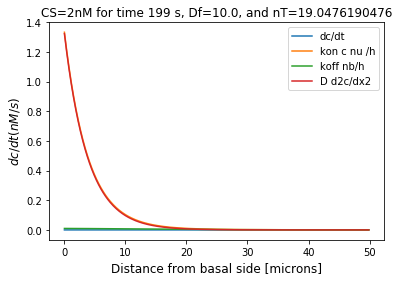

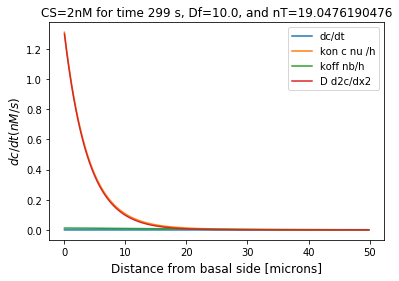

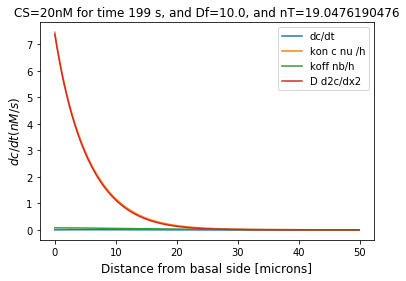

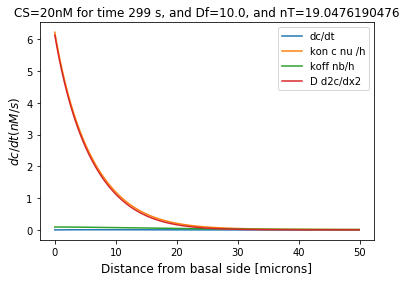

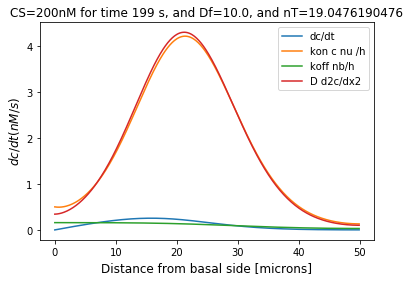

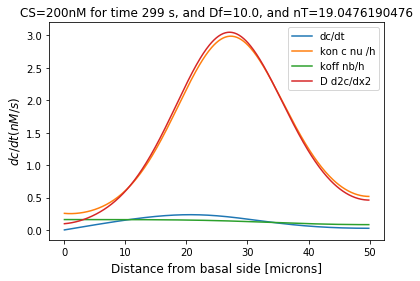

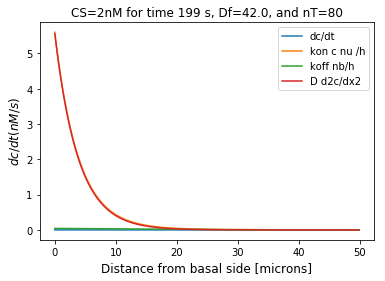

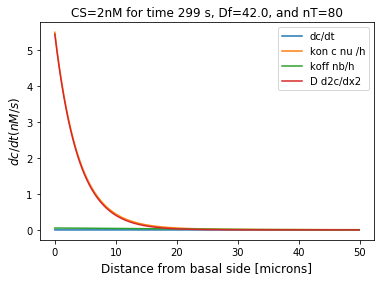

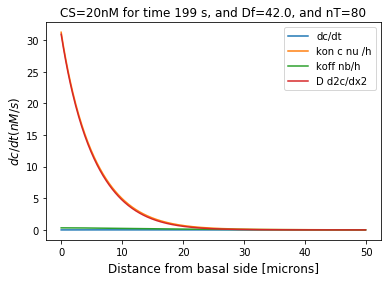

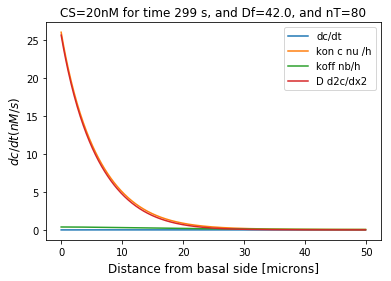

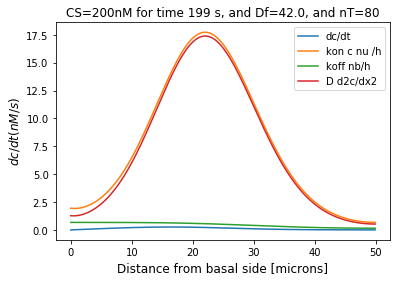

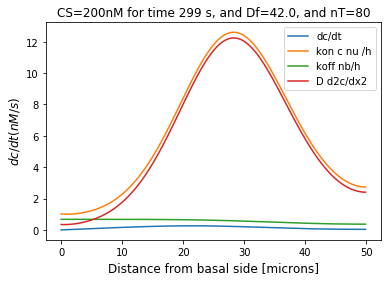

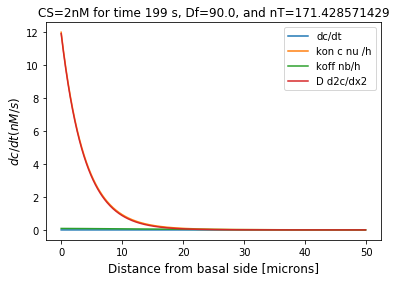

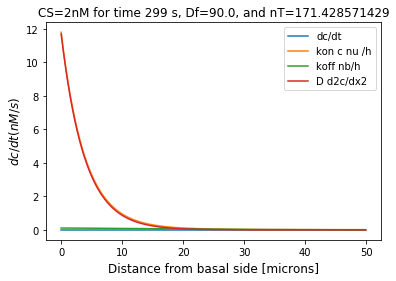

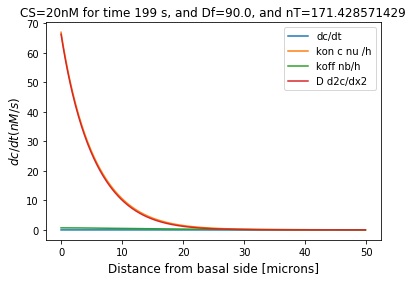

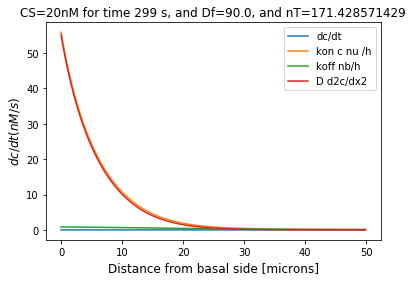

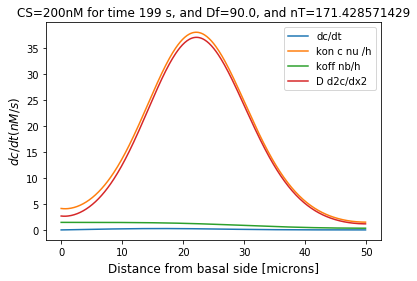

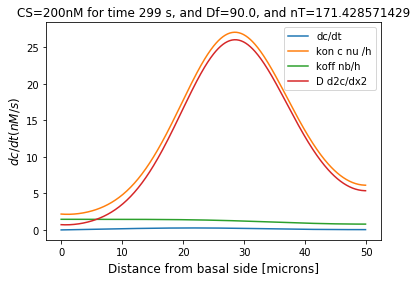

In [31]:
for D_f_test, nT_value in zip([10., 42., 90.], [80 * 10.0/ 42.0, 80, 80 * 90.0/ 42.0]):
    #initial conditions: no free GFP, no bound GFP, only unbound receptors.
    y0 = np.zeros(3*N_grid);
    y0[2::3] = nT_value
    y0 = np.squeeze(np.asarray(y0))
    S2, infodictold0 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 2.),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    #solution with bath concentration 20nM
    S20, infodictold0 = integrate.odeint(ode_invasion,
                                         y0,
                                         t0,
                                         args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                         full_output=True,
                                         rtol=tol,
                                         atol=tol)
    #solution with bath concentration 200nM
    S200, infodictold0 = integrate.odeint(ode_invasion,
                                          y0,
                                          t0,
                                          args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                          full_output=True,
                                          rtol=tol,
                                          atol=tol)
    ## plots for 2 nM
    Fsize = 12
    selected_times_array = [199, 299]
    CS = 2
    for time in selected_times_array: 
        #for each time, find the corresponding index in the list
        time_index = np.argmin(np.abs(t0 - time))
        #reimport concentration vectors and second derivative
        c = S2[time_index, 0::3]; nb = S2[time_index, 1::3]; nf = S2[time_index, 2::3];   
        d2c_dx2 = np.zeros_like(c)
        d2c_dx2[0] = 1.0 / dx ** 2 * (c[1] + CS - 2.0 * c[0]) 
        for i in np.arange(1, N_grid-1):
            d2c_dx2[i] = 1.0 / dx ** 2 * (c[i+1] + c[i-1] - 2 * c[i]) 
        d2c_dx2[-1] = 1.0 / dx ** 2 * (c[-2] - c[-1]) 

        plt.plot(X, np.array((S2[time_index+1, 0::3] - S2[time_index, 0::3]) / dt), label='dc/dt')
        plt.plot(X, k_on_value / h_value * c * nf , label='kon c nu /h')
        plt.plot(X, k_off_value / h_value * nb, label='koff nb/h')
        plt.plot(X, D_f_test * d2c_dx2, label='D d2c/dx2')
        plt.legend();
        plt.xlabel('Distance from basal side [microns]', fontsize=Fsize);
        plt.ylabel(r'$dc/dt (nM/s)$', fontsize=Fsize);
        plt.title('CS=2nM for time '+str(time)+' s, Df='+str(D_f_test)+', and nT='+str(nT_value), fontsize=Fsize)
        plt.show()

    ## plots for 20 nM
    CS = 20
    for time in selected_times_array: 
        #for each time, find the corresponding index in the list
        time_index = np.argmin(np.abs(t0 - time))
        #reimport concentration vectors and second derivative
        c = S20[time_index, 0::3]; nb = S20[time_index, 1::3]; nf = S20[time_index, 2::3];   
        d2c_dx2 = np.zeros_like(c)
        d2c_dx2[0] = 1.0 / dx ** 2 * (c[1] + CS - 2.0 * c[0]) 
        for i in np.arange(1, N_grid-1):
            d2c_dx2[i] = 1.0 / dx ** 2 * (c[i+1] + c[i-1] - 2 * c[i]) 
        d2c_dx2[-1] = 1.0 / dx ** 2 * (c[-2] - c[-1]) 


        plt.plot(X, np.array((S20[time_index+1, 0::3]-S20[time_index, 0::3])/dt), label='dc/dt')
        plt.plot(X, k_on_value /h_value * c * nf , label='kon c nu /h')
        plt.plot(X, k_off_value /h_value * nb, label='koff nb/h')
        plt.plot(X, D_f_test * d2c_dx2, label='D d2c/dx2')
        plt.legend();
        plt.xlabel('Distance from basal side [microns]', fontsize=Fsize);
        plt.ylabel(r'$dc/dt (nM/s)$', fontsize=Fsize);
        plt.title('CS=20nM for time '+str(time)+' s, and Df='+str(D_f_test)+', and nT='+str(nT_value), fontsize=Fsize)
        plt.show()



    ## plots for 200 nM
    CS = 200
    for time in selected_times_array: 
        #for each time, find the corresponding index in the list
        time_index = np.argmin(np.abs(t0 - time))
        #reimport concentration vectors and second derivative
        c = S200[time_index, 0::3]; nb = S200[time_index, 1::3]; nf = S200[time_index, 2::3];   
        d2c_dx2 = np.zeros_like(c)
        d2c_dx2[0] = 1.0 / dx ** 2 * (c[1] + CS - 2.0 * c[0]) 
        for i in np.arange(1, N_grid-1):
            d2c_dx2[i] = 1.0 / dx ** 2 * (c[i+1] + c[i-1] - 2 * c[i]) 
        d2c_dx2[-1] = 1.0 / dx ** 2 * (c[-2] - c[-1]) 
        plt.plot(X, np.array((S200[time_index+1, 0::3]
                              -S200[time_index, 0::3])/dt), label='dc/dt')
        plt.plot(X, k_on_value /h_value * c * nf , label='kon c nu /h')
        plt.plot(X, k_off_value /h_value * nb, label='koff nb/h')
        plt.plot(X, D_f_test * d2c_dx2, label='D d2c/dx2')
        plt.legend();
        plt.xlabel('Distance from basal side [microns]', fontsize=Fsize);
        plt.ylabel(r'$dc/dt (nM/s)$', fontsize=Fsize);
        plt.title('CS=200nM for time '+str(time)+' s, and Df='+str(D_f_test)+', and nT='+str(nT_value), fontsize=Fsize)
        plt.show()

Compare the full result with the quasi-static approximation

In [34]:
from scipy.integrate import solve_bvp
def fun_c(x_array, y, nb_array, nf_array, k_on, k_off, D_f, h):
    this_c_array = y[0]    
    nf = np.interp(x_array, X, nf_array)
    nb = np.interp(x_array, X, nb_array)
    val =  1.0 / h * (- k_on * nf * this_c_array + k_off * nb)
    return np.vstack((y[1], -val / D_f))    
def bc_c(ya, yb, C_S):
        return np.array([ya[0] - C_S, yb[1]])
global c_quasi_static    
def ode_invasion_quasi_static(y, t, D_f, D_r, k_on, k_off, L, h, C_S):
    """function which returns the time evolution of the 
    concentration fields c (free GFP), nb (GFP bound to receptor)
    nf (free receptor) 
    x=0 is the basal side in contact with the bath
    x=L is the apical side
    D_f the free diffusion of GFP
    D_r the diffusion of receptor in the membrane
    k_on the on-rate of ligands to receptor
    k_off the off-rate of ligands to receptor
    L the apico-basal distance
    h the size of the intercellular space
    C_S the concentraton in the bath
    """
    #vector containinig the time derivative for the fields
    dydt = np.zeros(2*N_grid);
    # extract the three fields from the vector y
    nb = y[0::2];
    nf = y[1::2]; 
    #calculate the solution for c - quasi- static
    dc = np.concatenate((np.diff(c), [0]))
    global c_quasi_static
    res= solve_bvp(lambda x,y: fun_c(x, y, nb, nf, k_on, k_off, D_f, h),
                     lambda ya, yb : bc_c(ya, yb, C_S),
                     X,
                     [c, dc],
                     tol=1.0e-10)
    c_quasi_static = res.sol(X)[0]
    #calculate time derivatives
    dnbdt = np.zeros(N_grid);
    dnfdt = np.zeros(N_grid)
    
   
        
    #near the bath, uses that the concentration in the bath is C_S (c[-1]=C_S)
    #and that there is a vanishing flux of nb and nf (nb[-1]=nb[0], nf[-1]=nf[0])
    dnbdt[0] = (D_r / dx ** 2 * (nb[1] - nb[0]) 
                + k_on * nf[0] * c_quasi_static[0] - k_off * nb[0])
    dnfdt[0] = (D_r / dx ** 2 * (nf[1] - nf[0])
                - k_on * nf[0] * c_quasi_static[0] + k_off * nb[0])
    #in bulk, standard discrete diffusion operator
    for i in np.arange(1, N_grid-1):
        dnbdt[i] = (D_r / dx ** 2 * (nb[i+1] + nb[i-1] - 2 * nb[i]) 
                    + k_on * nf[i] * c_quasi_static[i] - k_off * nb[i])
        dnfdt[i] = (D_r / dx ** 2 * (nf[i+1] + nf[i-1] - 2 * nf[i])
                    - k_on * nf[i] * c_quasi_static[i] + k_off * nb[i])
    #near the apical side, uses that there is a vanishing flux of c (c[N+1]=c[N]=c[-1])
    #and that there is a vanishing flux of nb and nf (nb[N+1]=nb[N], nf[N+1]=nf[N])
    dnbdt[-1] = (D_r / dx ** 2 *(nb[-2] - nb[-1])
                 + k_on * nf[-1] * c_quasi_static[-1] - k_off * nb[-1])
    dnfdt[-1] = (D_r/dx ** 2 * (nf[-2] - nf[-1]) 
                 - k_on * nf[-1] * c_quasi_static[-1] + k_off * nb[-1])    
    dydt[0::2] = dnbdt;
    dydt[1::2] = dnfdt; 
    return np.squeeze(np.asarray(dydt))

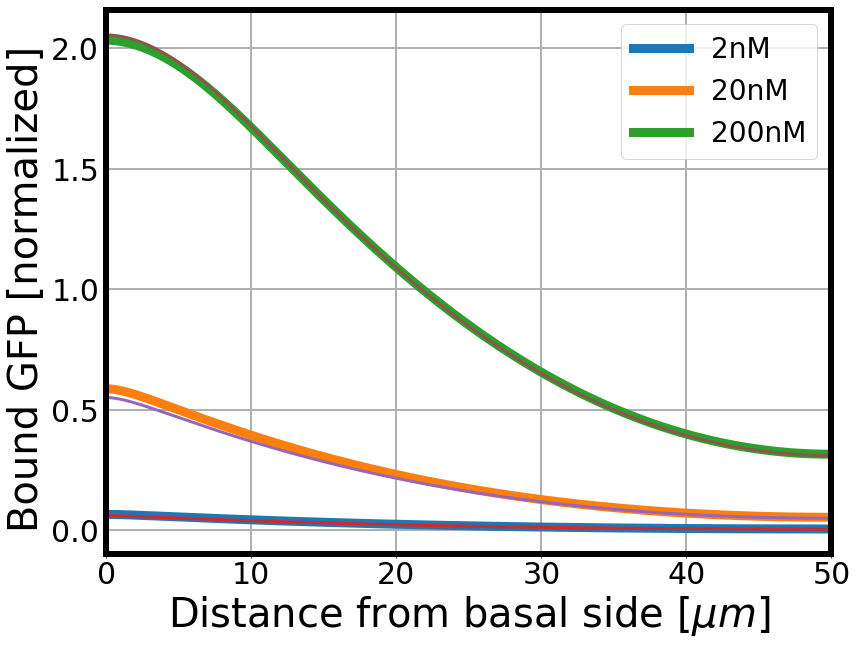

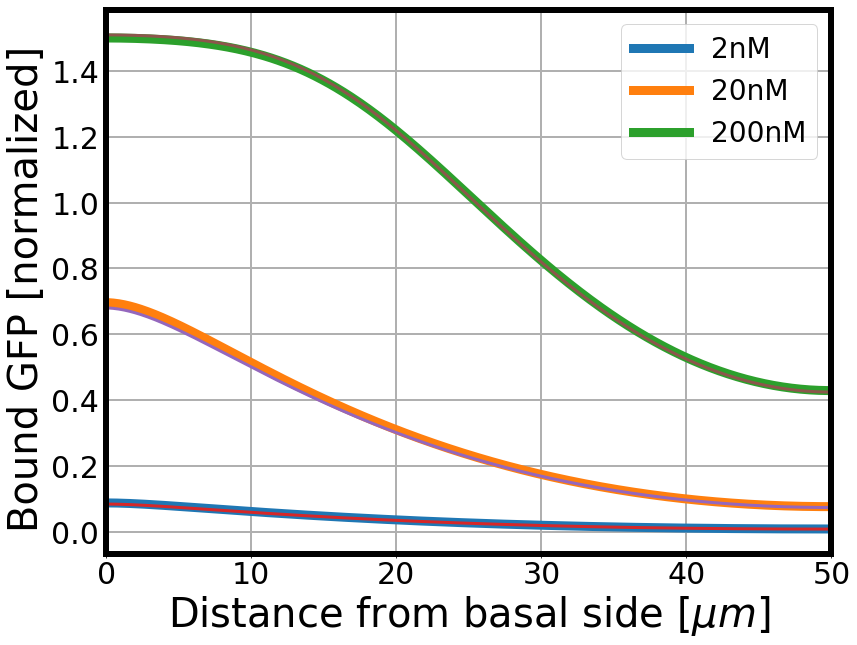

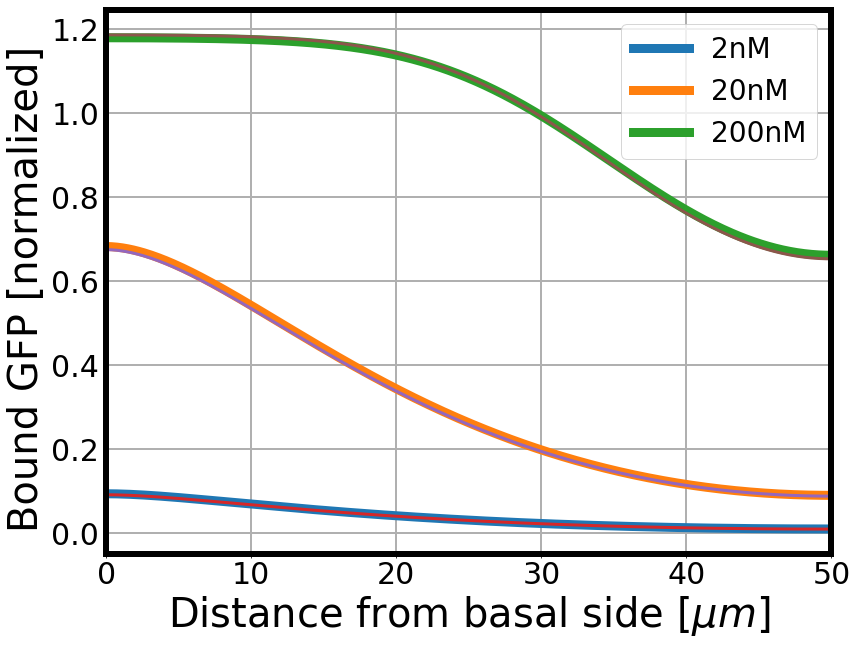

In [35]:
for D_f_test in [10, 42, 90.]:
    #calculate result without quasi-static approximation
    #initial conditions: no free GFP, no bound GFP, only unbound receptors.
    y0 = np.zeros(3*N_grid);
    y0[2::3] = nT_value
    y0 = np.squeeze(np.asarray(y0))
    S2, infodictold0 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 2.),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    #solution with bath concentration 20nM
    S20, infodictold0 = integrate.odeint(ode_invasion,
                                         y0,
                                         t0,
                                         args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                         full_output=True,
                                         rtol=tol,
                                         atol=tol)
    #solution with bath concentration 200nM
    S200, infodictold0 = integrate.odeint(ode_invasion,
                                          y0,
                                          t0,
                                          args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                          full_output=True,
                                          rtol=tol,
                                          atol=tol)
    # Record Bound profiles (used for the statistical analysis):
    nb2 = S200[:,1::3]
    m = np.mean(nb2[-1])
    nb0 = S2[:,1::3][-1] / m
    nb1 = S20[:,1::3][-1] / m
    nb2 = S200[:,1::3][-1] / m
    #now calculate result with quasi-static approximation
    #initial conditions: no free GFP, no bound GFP, only unbound receptors.
    c_quasi_static = np.zeros(N_grid)
    y0 = np.zeros(2*N_grid);
    y0[1::2] = nT_value
    y0 = np.squeeze(np.asarray(y0))
    #solution with bath concentration 2nM
    S2_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                    y0,
                                                    t0,
                                                    args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 2.,),
                                                    full_output=True,
                                                    rtol=tol,
                                                    atol=tol)
    #solution with bath concentration 20nM
    S20_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                     y0,
                                                     t0,
                                                     args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                                     full_output=True,
                                                     rtol=tol,
                                                     atol=tol)
    #solution with bath concentration 200nM
    S200_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                      y0,
                                                      t0,
                                                      args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                                      full_output=True,
                                                      rtol=tol,
                                                      atol=tol)
    # Record and plot profiles
    nb2_quasistatic = S200_quasistatic[:,0::2]
    m = np.mean(nb2_quasistatic[-1])
    nb0_quasistatic = S2_quasistatic[:,0::2][-1] / m
    nb1_quasistatic = S20_quasistatic[:,0::2][-1] / m
    nb2_quasistatic = S200_quasistatic[:,0::2][-1] / m
    f=plt.figure(figsize = (13, 10))
    ax1 = plt.subplot(111)
    ax1.plot(X, nb0_quasistatic, label = "2nM QS", lw=9, ms = 10)
    ax1.plot(X, nb1_quasistatic, label = "20nM QS", lw=9, ms = 10)
    ax1.plot(X, nb2_quasistatic, label = "200nM QS", lw=9, ms = 10)
    ax1.plot(X, nb0, label = "2nM", lw=3, ms = 10)
    ax1.plot(X, nb1, label = "20nM", lw=3, ms = 10)
    ax1.plot(X, nb2, label = "200nM", lw=3, ms = 10)
    ax1.set_xlim(-5, 50)
    plt.tick_params(labelsize=30)
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(6)
    plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
    plt.xlabel(r"Distance from basal side $[\mu m] $",fontsize =40)
    plt.legend(['2nM','20nM','200nM'],fontsize=28)
    plt.grid(lw=2)
    plt.xlim([0, 50])
    plt.show()

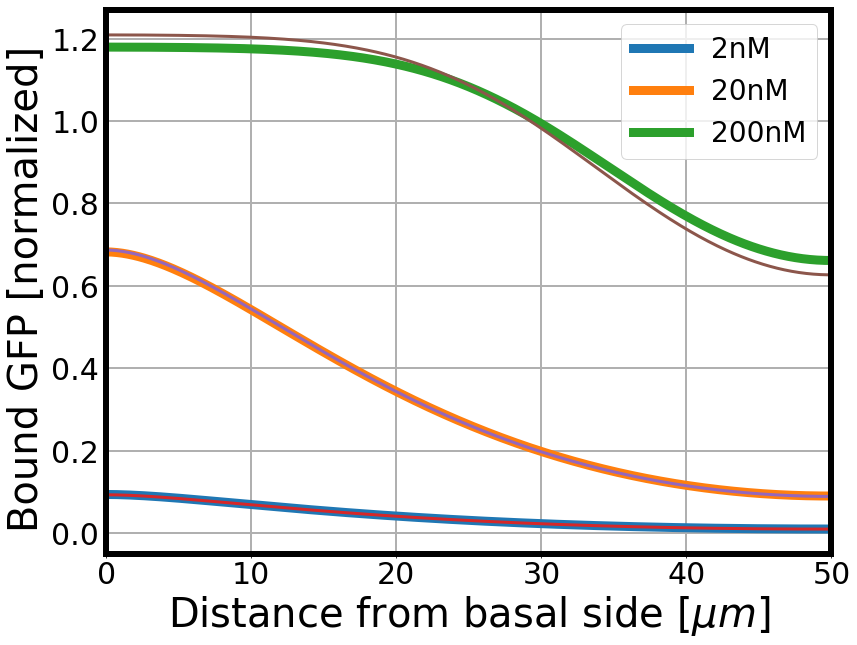

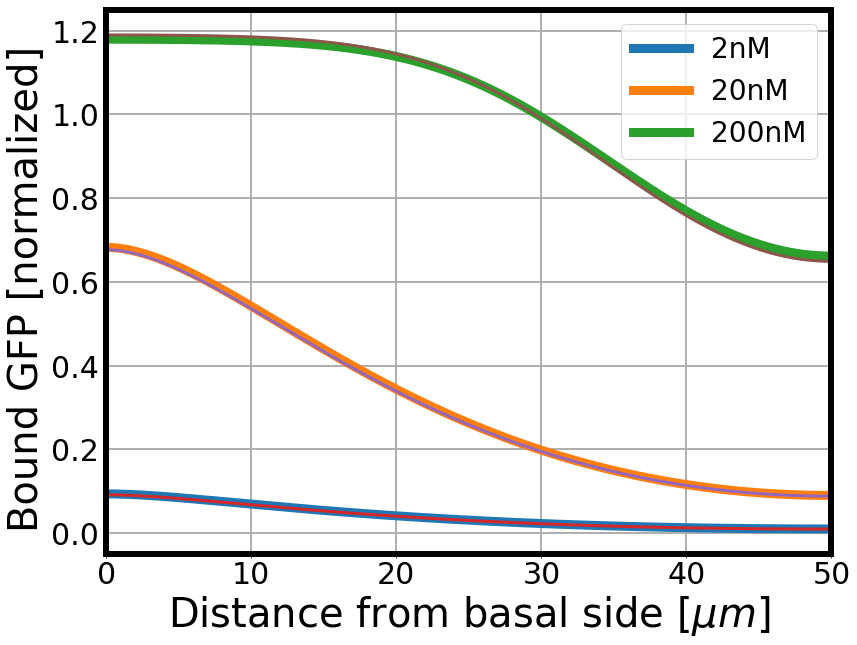

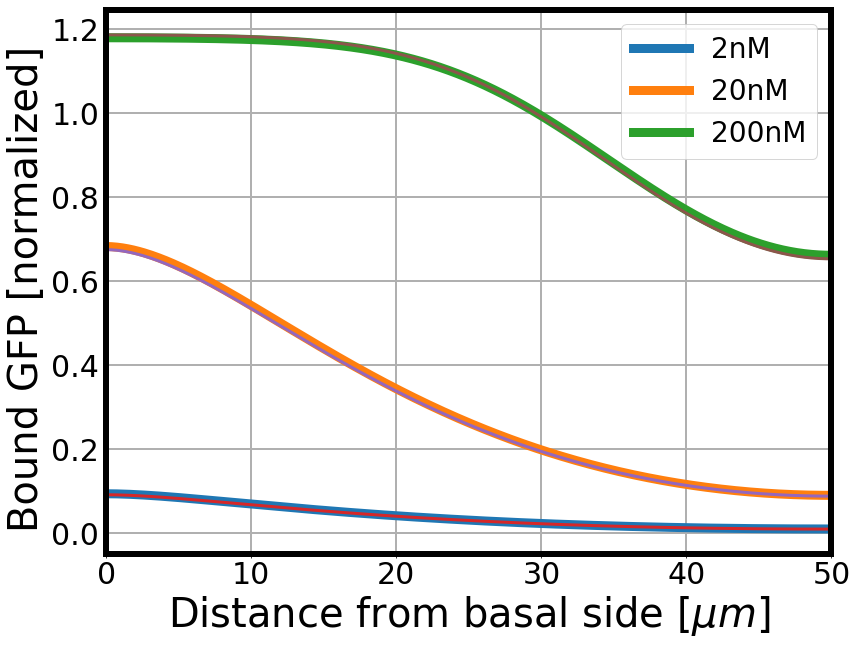

In [37]:
for (D_f_test, nT_value) in zip([10, 42, 90.], [80*10.0/42.0, 80, 80*90.0/42.0]):
    #calculate result without quasi-static approximation
    #initial conditions: no free GFP, no bound GFP, only unbound receptors.
    y0 = np.zeros(3*N_grid);
    y0[2::3] = nT_value
    y0 = np.squeeze(np.asarray(y0))
    S2, infodictold0 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 2.),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    #solution with bath concentration 20nM
    S20, infodictold0 = integrate.odeint(ode_invasion,
                                         y0,
                                         t0,
                                         args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                         full_output=True,
                                         rtol=tol,
                                         atol=tol)
    #solution with bath concentration 200nM
    S200, infodictold0 = integrate.odeint(ode_invasion,
                                          y0,
                                          t0,
                                          args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                          full_output=True,
                                          rtol=tol,
                                          atol=tol)
    # Record Bound profiles (used for the statistical analysis):
    nb2 = S200[:,1::3]
    m = np.mean(nb2[-1])
    nb0 = S2[:,1::3][-1] / m
    nb1 = S20[:,1::3][-1] / m
    nb2 = S200[:,1::3][-1] / m
    #now calculate result with quasi-static approximation
    #initial conditions: no free GFP, no bound GFP, only unbound receptors.
    c_quasi_static = np.zeros(N_grid)
    y0 = np.zeros(2*N_grid);
    y0[1::2] = nT_value
    y0 = np.squeeze(np.asarray(y0))
    #solution with bath concentration 2nM
    S2_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                    y0,
                                                    t0,
                                                    args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 2.,),
                                                    full_output=True,
                                                    rtol=tol,
                                                    atol=tol)
    #solution with bath concentration 20nM
    S20_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                     y0,
                                                     t0,
                                                     args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 20.),
                                                     full_output=True,
                                                     rtol=tol,
                                                     atol=tol)
    #solution with bath concentration 200nM
    S200_quasistatic, infodictold0 = integrate.odeint(ode_invasion_quasi_static,
                                                      y0,
                                                      t0,
                                                      args=(D_f_test, D_r_value, k_on_value, k_off_value, L, h_value, 200.),
                                                      full_output=True,
                                                      rtol=tol,
                                                      atol=tol)
    # Record and plot profiles
    nb2_quasistatic = S200_quasistatic[:,0::2]
    m = np.mean(nb2_quasistatic[-1])
    nb0_quasistatic = S2_quasistatic[:,0::2][-1] / m
    nb1_quasistatic = S20_quasistatic[:,0::2][-1] / m
    nb2_quasistatic = S200_quasistatic[:,0::2][-1] / m
    f=plt.figure(figsize = (13, 10))
    ax1 = plt.subplot(111)
    ax1.plot(X, nb0_quasistatic, label = "2nM", lw=9, ms = 10)
    ax1.plot(X, nb1_quasistatic, label = "20nM", lw=9, ms = 10)
    ax1.plot(X, nb2_quasistatic, label = "200nM", lw=9, ms = 10)
    ax1.plot(X, nb0, label = "2nM", lw=3, ms = 10)
    ax1.plot(X, nb1, label = "20nM", lw=3, ms = 10)
    ax1.plot(X, nb2, label = "200nM", lw=3, ms = 10)
    ax1.set_xlim(-5, 50)
    plt.tick_params(labelsize=30)
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(6)
    plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
    plt.xlabel(r"Distance from basal side $[\mu m] $",fontsize =40)
    plt.legend(['2nM','20nM','200nM'],fontsize=28)
    plt.grid(lw=2)
    plt.xlim([0, 50])
    plt.show()

## Perform a fit to experimental data

Collect and plot data 

In [38]:
#collect data 
import os
this_directory = os.getcwd()
path_to_data = this_directory + '/Experimental_Data/'
inv2 = pd.read_csv(path_to_data+'invasion_2nM.csv',sep=',')
inv20 = pd.read_csv(path_to_data+'invasion_20nM.csv',sep=',')
inv200 = pd.read_csv(path_to_data+'invasion_200nM.csv',sep=',')
# => normalization to value for invasion with a 200nM concentration bath
M = inv200['signal_mean'].mean() 
#interpolate data on the simulation grid
data_2nM = []
for i in range(6) : 
    data_2nM.append(np.interp(X, inv2['X'], inv2['Y'+str(i)+'_m'])/M)
data_20nM=[]
for i in range(9) :
    if i!=6 :
        data_20nM.append(np.interp(X, inv20['X'], inv20['Y'+str(i)])/M)
data_200nM=[]
for i in range(10) :
    data_200nM.append(np.interp(X, inv200['X'], inv200['Y'+str(i)])/M)

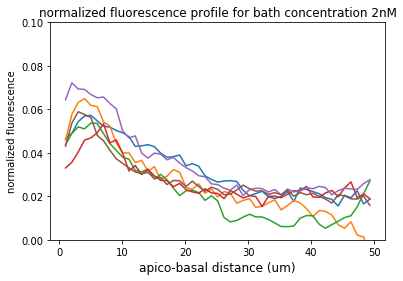

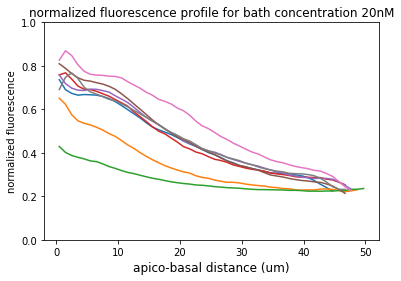

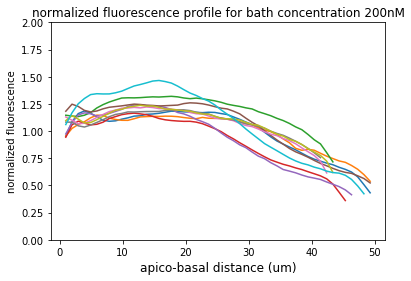

In [39]:
##Plot data :
Fsize = 12
for i in range(6) : 
    plt.plot(inv2['X'], inv2['Y'+str(i)+'_m'] / M)
    #plt.plot(X, data_2nM[i])
plt.xlabel('apico-basal distance (um)', fontsize=Fsize)
plt.ylabel('normalized fluorescence')
plt.title('normalized fluorescence profile for bath concentration 2nM')
plt.ylim([0, 0.1])
plt.show()
for i in range(9) : 
    if i!=6 :
        plt.plot(inv20['X'], inv20['Y'+str(i)] / M)
    #plt.plot(X, data_20nM[i])
plt.xlabel('apico-basal distance (um)', fontsize=Fsize)
plt.ylabel('normalized fluorescence')
plt.title('normalized fluorescence profile for bath concentration 20nM')
plt.ylim([0, 1])
plt.show()
for i in range(10) :
    plt.plot(inv200['X'], inv200['Y'+str(i)] / M)
plt.xlabel('apico-basal distance (um)', fontsize=Fsize)
plt.ylabel('normalized fluorescence')
plt.title('normalized fluorescence profile for bath concentration 200nM')
plt.ylim([0, 2])
plt.show()

In [12]:
#time array, going up to 300 s
t0=np.linspace(0, 300, 301)
#define fit function
def fit_function(D_f, D_r, nT, k_on, k_off) :    
        print('D_f, D_r, nT: ', D_f, D_r, nT)
        y0 = np.zeros(3*N_grid);
        y0[2::3] = nT
        y0=np.squeeze(np.asarray(y0))
        Energy = 0
        cs0 = 2.; cs1 = 20.; cs2 = 200.;
        S0, infodictold0 = integrate.odeint(ode_invasion,
                                            y0,
                                            t0,
                                            args=(D_f, D_r, k_on, k_off, L, h_value, cs0),
                                            full_output=True,
                                            rtol=tol,
                                            atol=tol)
        S1, infodictold1 = integrate.odeint(ode_invasion,
                                            y0,
                                            t0,
                                            args=(D_f, D_r, k_on, k_off, L, h_value, cs1),
                                            full_output=True,
                                            rtol=tol,
                                            atol=tol)
        S2, infodictold2 = integrate.odeint(ode_invasion,
                                            y0,
                                            t0,
                                            args=(D_f, D_r, k_on, k_off, L, h_value, cs2),
                                            full_output=True,
                                            rtol=tol,
                                            atol=tol)
        nb2_all = S2[:,1::3]
        m=np.mean(nb2_all[300]) #normalization to value for invasion with a 200nM concentration bath
        #normalized profiles of nb for the 3 bath concentrations
        nb0 = S0[:,1::3][300] / m
        nb1 = S1[:,1::3][300] / m
        nb2 = S2[:,1::3][300] / m
        #calculate the objective function by summing deviations with experimental data
        for i in range(6):
            Energy += np.sum(np.square(nb0 - data_2nM[i]))
        for i in range(8):
            Energy += np.sum(np.square(nb1[~np.isnan(data_20nM[i])] - data_20nM[i][~np.isnan(data_20nM[i])]))
        for i in range(10):
            Energy += np.sum(np.square(nb2[~np.isnan(data_200nM[i])]-data_200nM[i][~np.isnan(data_200nM[i])]))
        print('Energy =', Energy)
        return Energy
#perform minimization of the objective function 
res = minimize(lambda x: fit_function(D_f_value, x[0], x[1], k_on_value, k_off_value),
               [1.357020463748432, 80.11925665943144],
               method = 'Nelder-Mead')
print('Optimal values of Dr and nT, taking D=42:', res.x)

D_f, D_r, nT:  42.0 1.357020463748432 80.11925665943144
Energy = 107.46004790166228
D_f, D_r, nT:  42.0 1.4248714869358536 80.11925665943144
Energy = 107.86992515577444
D_f, D_r, nT:  42.0 1.357020463748432 84.12521949240302
Energy = 108.5952014387272
D_f, D_r, nT:  42.0 1.4248714869358539 76.11329382645987
Energy = 110.06306183563426
D_f, D_r, nT:  42.0 1.3739832195452875 82.12223807591724
Energy = 107.65630390488671
D_f, D_r, nT:  42.0 1.306132196357866 82.12223807591724
Energy = 108.4035529726015
D_f, D_r, nT:  42.0 1.3951866642913568 80.62000201355289
Energy = 107.54399883065854
D_f, D_r, nT:  42.0 1.3782239084945014 78.6170205970671
Energy = 107.78645817552837
D_f, D_r, nT:  42.0 1.375043391782591 81.24593370620471
Energy = 107.51134289366152
D_f, D_r, nT:  42.0 1.3368771912396662 80.74518835208326
Energy = 107.57591248822126
D_f, D_r, nT:  42.0 1.3806092960284342 80.65129859818549
Energy = 107.48796640339513
D_f, D_r, nT:  42.0 1.3625863679942753 79.52462155141222
Energy = 107.50

Test for changes in parameters when the diffusion of free GFP is taken within an interval. Tested here for 10<D<90

In [15]:
IC=np.array([ 1.357, 80*90./D_f_value])
res = minimize(lambda x: fit_function(90.,x[0],x[1], k_on_value, k_off_value),IC,method = 'Nelder-Mead',tol=1e-2)
print('Optimal values of Dr and nT, taking D=90:', res.x)
IC=np.array([ 1.357, 80*10./D_f_value])
res = minimize(lambda x: fit_function(10.,x[0],x[1], k_on_value, k_off_value),IC,method = 'Nelder-Mead',tol=1e-2)
print('Optimal values of Dr and nT, taking D=10:', res.x)

D_f, D_r, nT:  90.0 1.357 171.42857142857142
Energy = 107.97568367397284
D_f, D_r, nT:  90.0 1.42485 171.42857142857142
Energy = 108.6008927662781
D_f, D_r, nT:  90.0 1.357 180.0
Energy = 108.6468927335626
D_f, D_r, nT:  90.0 1.42485 162.85714285714283
Energy = 111.36267437508938
D_f, D_r, nT:  90.0 1.3739625 175.71428571428572
Energy = 107.98396374677424
D_f, D_r, nT:  90.0 1.3061125 175.7142857142857
Energy = 108.49856224547327
D_f, D_r, nT:  90.0 1.3357968749999998 174.6428571428571
Energy = 108.04924919301334
D_f, D_r, nT:  90.0 1.3951656250000002 172.5
Energy = 108.12000253576531
D_f, D_r, nT:  90.0 1.3506390625 174.10714285714283
Energy = 107.94953484929448
D_f, D_r, nT:  90.0 1.3336765625000002 169.8214285714285
Energy = 108.02177795016593
D_f, D_r, nT:  90.0 1.3638910156250001 174.24107142857142
Energy = 107.93564712021521
D_f, D_r, nT:  90.0 1.3575300781250002 176.9196428571428
Energy = 108.14213308368338
D_f, D_r, nT:  90.0 1.35713251953125 172.80133928571428
Energy = 107.926

## Bootstrapping method
> Show an example of the principle behind the calculation of uncertainty through a fit to synthetic data.

## Adding a noisy term with magnitude the standard deviation of the experimental curve : 

> Show an example of generated synthetic data.

In [40]:
## collect data
this_directory='./'
path_to_data = this_directory + '/Experimental_Data/'
inv2 = pd.read_csv(path_to_data+'invasion_2nM.csv',sep=',')
inv20 = pd.read_csv(path_to_data+'invasion_20nM.csv',sep=',')
inv200 = pd.read_csv(path_to_data+'invasion_200nM.csv',sep=',')
# => normalization to value for invasion with a 200nM concentration bath
M = inv200['signal_mean'].mean() 
#interpolate data on the simulation grid
data_2nM = []
for i in range(6) : 
    data_2nM.append(np.interp(X, inv2['X'], inv2['Y'+str(i)+'_m'])/M)
data_20nM=[]
for i in range(9) :
    if i!=6 :
        data_20nM.append(np.interp(X, inv20['X'], inv20['Y'+str(i)])/M)
data_200nM=[]
for i in range(10) :
    data_200nM.append(np.interp(X, inv200['X'], inv200['Y'+str(i)])/M)

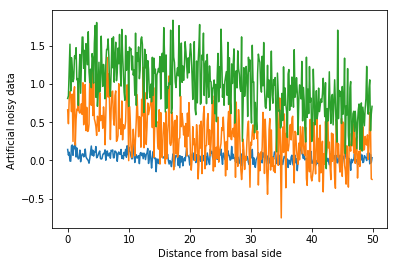

In [44]:
residuals_2nM = []
for i in range(6):
    residuals_2nM.extend(nb0 - data_2nM[i])
residuals_20nM = []    
for i in range(8):
    residuals_20nM.extend(nb1[~np.isnan(data_20nM[i])] - data_20nM[i][~np.isnan(data_20nM[i])])
residuals_200nM = []   
for i in range(10):
    residuals_200nM.extend(nb2[~np.isnan(data_200nM[i])]-data_200nM[i][~np.isnan(data_200nM[i])])
   
    
## use maximum residual for the std of the distribution:


std_m0=np.max(np.abs(residuals_2nM))
std_m1=np.max(np.abs(residuals_20nM))
std_m2=np.max(np.abs(residuals_200nM))
#generate synthetic data
data2_max=[];data20_max=[];data200_max=[]
for i in range(len(data_2nM)):
    data2_max.append(nb0+std_m0*np.random.normal(0,1,size=(len(nb0))))
for i in range(len(data_20nM)):
    data20_max.append(nb1+std_m1*np.random.normal(0,1,size=(len(nb1))))
for i in range(len(data_200nM)):
    data200_max.append(nb2+std_m2*np.random.normal(0,1,size=(len(nb2))))

plt.figure();
plt.plot(X,data2_max[0])
plt.plot(X,data20_max[0])
plt.plot(X,data200_max[0])
plt.xlabel('Distance from basal side')
plt.ylabel('Artificial noisy data ')
plt.show()


In [42]:
def fit_function_max(D_f, D_r, nT, k_on, k_off):
    print('D_f, D_r, nT: ', D_f, D_r, nT)
    y0 = np.zeros(3*N_grid);
    y0[2::3] = nT
    y0=np.squeeze(np.asarray(y0))

    cs0 = 2.; cs1 = 20.; cs2 = 200.;
    S0, infodictold0 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f, D_r, k_on, k_off, L, h_value, cs0),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    S1, infodictold1 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f, D_r, k_on, k_off, L, h_value, cs1),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    S2, infodictold2 = integrate.odeint(ode_invasion,
                                        y0,
                                        t0,
                                        args=(D_f, D_r, k_on, k_off, L, h_value, cs2),
                                        full_output=True,
                                        rtol=tol,
                                        atol=tol)
    nb2_all = S2[:,1::3]
    m=np.mean(nb2_all[300]) #normalization to value for invasion with a 200nM concentration bath
    #normalized profiles of nb for the 3 bath concentrations
    nb0 = S0[:,1::3][-1] / m
    nb1 = S1[:,1::3][-1] / m
    nb2 = S2[:,1::3][-1] / m
    Energy = 0
    for i in range(6):
        Energy+=np.sum(np.square(nb0-data2_max[i]))
    for i in range(8):
        Energy+=np.sum(np.square(nb1[~np.isnan(data20_max[i])]-data20_max[i][~np.isnan(data20_max[i])]))
    for i in range(10):
        Energy+=np.sum(np.square(nb2[~np.isnan(data200_max[i])]-data200_max[i][~np.isnan(data200_max[i])]))
    print 'Energy', Energy
    return Energy


In [ ]:
res_max = minimize(lambda x: fit_function_max(D_f_value, x[0], x[1], k_on_value, k_off_value),
               [ 1.356, 80],
               method = 'Nelder-Mead',
               tol=1.0e-2)

('D_f, D_r, nT: ', 42.0, 1.356, 80.0)
Energy 646.4203072859951
('D_f, D_r, nT: ', 42.0, 1.4238000000000002, 80.0)
Energy 645.330422276257
('D_f, D_r, nT: ', 42.0, 1.356, 84.0)
Energy 649.903157850481
('D_f, D_r, nT: ', 42.0, 1.4238000000000002, 76.0)
Energy 645.5523824903427
('D_f, D_r, nT: ', 42.0, 1.4916000000000003, 76.0)
Energy 646.6438730832922
('D_f, D_r, nT: ', 42.0, 1.3899000000000001, 79.0)
Energy 645.3927029042762
('D_f, D_r, nT: ', 42.0, 1.3899000000000001, 83.0)
Energy 647.6418484596971
('D_f, D_r, nT: ', 42.0, 1.4153250000000002, 77.75)
Energy 645.1201088913615
('D_f, D_r, nT: ', 42.0, 1.449225, 78.75)
Energy 645.1214538078116
('D_f, D_r, nT: ', 42.0, 1.4407500000000002, 76.5)
Energy 645.5373758827687
('D_f, D_r, nT: ', 42.0, 1.4280375000000003, 79.125)
Energy 645.1427699644319
('D_f, D_r, nT: ', 42.0, 1.4365125, 77.375)
Energy 645.2409364269447
('D_f, D_r, nT: ', 42.0, 1.4301562500000002, 78.6875)
Energy 645.107153376903
('D_f, D_r, nT: ', 42.0, 1.3962562500000006, 77.687